- Calculate `purchase sum` and `transaction count` from input data for period '2018-09-01' to '2020-01-31'.
- Obtain macroeconomic data from Stats Canada in the last 3 years.
- Select the eco data for period '2018-09-01' to '2020-01-31' and train GLM to forecast `transaction count`.
- Forecast eco data for next month.
- Use forecasted eco data to forecast transaction count for next month.

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn import preprocessing
from sklearn.metrics import r2_score

import stats_can
from fbprophet import Prophet
from datetime import datetime
import sys

In [2]:
df = pd.read_csv('data/cc_data_processed.csv')

In [3]:
# Use date as index
df.index = pd.to_datetime(df['Transaction Date'])
df.drop('Transaction Date', axis = 1, inplace = True, errors='ignore')
df.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Age
Transaction Date,,,,,,
2019-07-01,credit_card,male,Red Robin,Eating Places,15.52,22.0
2019-09-30,bank_account,male,California Thai,Eating Places,11.29,30.0
2019-06-24,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,34.0
2018-10-01,bank_account,female,The Beer Store,Other,88.90,43.0
2019-12-01,bank_account,male,Intermarche,Grocery Stores,23.54,62.0


In [4]:
# table with transaction counts and total amount aggregated for each month
df_group = df.groupby([pd.Grouper(freq = 'M')]).agg({'Purchase Amount': {'count', 'sum'}}).rename(columns={'count':'Transaction_Count','sum':'Purchase_Sum'})
df_group.columns = df_group.columns.droplevel(0)
df_group.head()

,Purchase_Sum,Transaction_Count
Transaction Date,,
2016-04-30,103.81,12
2016-05-31,967.50,31
2016-06-30,1346.28,48
2016-07-31,1645.19,58
2016-08-31,2971.88,88


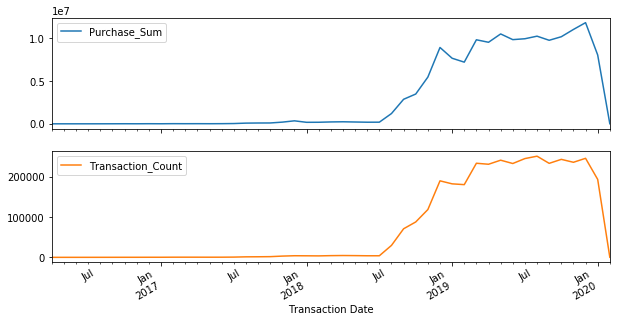

In [5]:
df_group.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));

                  Purchase_Sum  Transaction_Count
Transaction Date                                 
2018-09-30        2.864154e+06              70906
2018-10-31        3.476955e+06              87826
2018-11-30        5.455445e+06             118630
2018-12-31        8.910758e+06             189849
2019-01-31        7.653694e+06             182379
2019-02-28        7.199211e+06             180404
2019-03-31        9.809226e+06             233468
2019-04-30        9.517425e+06             230990
2019-05-31        1.049074e+07             241047
2019-06-30        9.825952e+06             232827
2019-07-31        9.930230e+06             245095
2019-08-31        1.023078e+07             250985
2019-09-30        9.750168e+06             233238
2019-10-31        1.016536e+07             243126
2019-11-30        1.101461e+07             235863
2019-12-31        1.180695e+07             245742
2020-01-31        8.032002e+06             193349


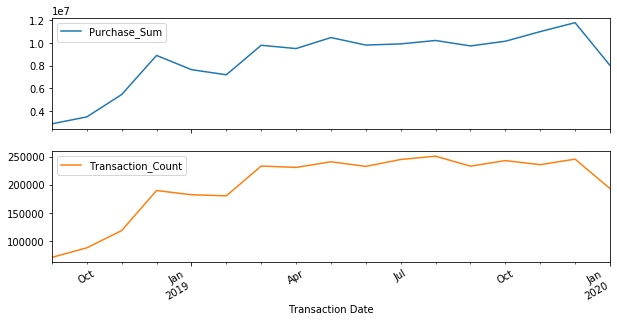

In [6]:
# only keep data from Sep 2018 to Jan 2020
df_period = df_group.loc['2018-09-01':'2020-01-31']
#df_period = df_group.loc['2018-09-01':'2019-12-31']
df_period.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));
print(df_period) # 17 month in total

In [7]:
# load marco-economic data from statistics Canada
eco_vec_map = {'CPI':'v41690973',
               'Exchange_Rate_USD':'v111666275',
               'GDP':'v65201210',
               'Unemployment_Rate':'v91506256',
               'TSX':'v122620'}
vectors = list(eco_vec_map.values())
df_eco = stats_can.sc.vectors_to_df(vectors, periods = 36) # get data in the last 36 months
inv_map = {v: k for k, v in eco_vec_map.items()}
df_eco.columns = df_eco.columns.to_series().map(inv_map)
df_eco.index.names = ['Date']

# Extract eco data from Sep 2018 to Jan 2020
df_eco_sel = df_eco.loc['2018-09-01':'2020-01-31']

In [8]:
df_eco

,TSX,CPI,GDP,Unemployment_Rate,Exchange_Rate_USD
Date,,,,,
2017-09-01,NaN,NaN,1905358.0,NaN,NaN
2017-10-01,16025.59,NaN,1907384.0,NaN,NaN
2017-11-01,16067.48,131.3,1917258.0,5.4,1.2769
2017-12-01,16209.13,130.8,1922552.0,5.3,1.2771
2018-01-01,15951.67,131.7,1920911.0,6.2,1.2427
2018-02-01,15442.68,132.5,1926421.0,6.1,1.2586
2018-03-01,15367.29,132.9,1931188.0,6.3,1.2932
2018-04-01,15607.88,133.3,1930135.0,6.1,1.2733
2018-05-01,16061.50,133.4,1938797.0,5.9,1.2873


In [9]:
# load marco economic data
#df_eco = pd.read_csv('data/eco/macro_economic_data.csv')

# Extract eco data from Sep 2018 to Jan 2020
#df_eco.index = pd.to_datetime(df_eco['Date'])
#df_eco.drop('Date',axis = 1, inplace = True, errors='ignore')
#df_eco = df_eco.loc['2018-09-01':'2020-01-31']
#df_eco = df_eco.loc['2018-09-01':'2019-12-31']

In [10]:
df_all = pd.concat([df_eco_sel, df_period.set_index(df_eco_sel.index)], axis=1)
df_all.head(20)

,TSX,CPI,GDP,Unemployment_Rate,Exchange_Rate_USD,Purchase_Sum,Transaction_Count
Date,,,,,,,
2018-09-01,16073.14,133.7,1948264.0,5.4,1.3037,2.864154e+06,70906
2018-10-01,15027.28,134.1,1951927.0,5.3,1.3010,3.476955e+06,87826
2018-11-01,15197.82,133.5,1947407.0,5.2,1.3200,5.455445e+06,118630
2018-12-01,14322.86,133.4,1947565.0,5.2,1.3432,8.910758e+06,189849
2019-01-01,15540.60,133.6,1950955.0,6.2,1.3301,7.653694e+06,182379
2019-02-01,15999.01,134.5,1947760.0,6.1,1.3206,7.199211e+06,180404
2019-03-01,16102.09,135.4,1960078.0,6.2,1.3368,9.809226e+06,233468
2019-04-01,16580.73,136.0,1966041.0,5.9,1.3378,9.517425e+06,230990
2019-05-01,16037.49,136.6,1972475.0,5.5,1.3459,1.049074e+07,241047


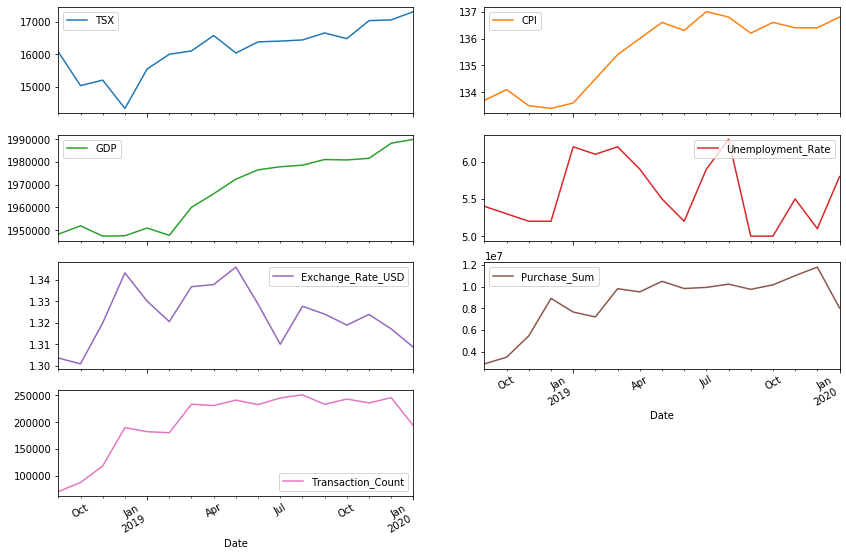

In [11]:
df_all.plot(subplots = True,figsize=(14,10),layout=(4, 2));

In [12]:
#y_train = df_all['Purchase_Sum'].values
y_train = df_all['Transaction_Count'].values
X_train = df_all[['CPI','Exchange_Rate_USD','GDP','Unemployment_Rate','TSX']]
#X_train = df_all[['CPI','Exchange_Rate_USD','GDP','TSX']]

In [13]:
X_train

,CPI,Exchange_Rate_USD,GDP,Unemployment_Rate,TSX
Date,,,,,
2018-09-01,133.7,1.3037,1948264.0,5.4,16073.14
2018-10-01,134.1,1.3010,1951927.0,5.3,15027.28
2018-11-01,133.5,1.3200,1947407.0,5.2,15197.82
2018-12-01,133.4,1.3432,1947565.0,5.2,14322.86
2019-01-01,133.6,1.3301,1950955.0,6.2,15540.60
2019-02-01,134.5,1.3206,1947760.0,6.1,15999.01
2019-03-01,135.4,1.3368,1960078.0,6.2,16102.09
2019-04-01,136.0,1.3378,1966041.0,5.9,16580.73
2019-05-01,136.6,1.3459,1972475.0,5.5,16037.49


In [14]:
# regression with sklearn
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_train)
print("Linear regression R square: %.2f" % r2_score(y_train, y_pred))

Linear regression R square: 0.89


In [15]:
# regression with stats
X_train_addC = sm.add_constant(X_train)
lm_stats = sm.OLS(y_train,X_train_addC)
lm_stats.fit().summary()

d:\anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     17.10
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           7.35e-05
Time:                        11:00:57   Log-Likelihood:                -191.40
No. Observations:                  17   AIC:                             394.8
Df Residuals:                      11   BIC:                             399.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -8.443e+06   1.41e+06     -5.972      0.000   -1.16e+07   -5.33e+06
CPI                1.558e+04   1.41e+04      1.107      0.292   -1.54e+04    4.66e+04
Exchange_Rate_USD  2.187e+06   5.01e+05      4.370      0.001    1.09e+06    3.29e+06
GDP                   1.8627      1.362      1.367      0.199      -1.136       4.861
Unemployment_Rate  1.752e+04   1.64e+04      1.069      0.308   -1.86e+04    5.36e+04
TSX                  -7.7524     15.953     -0.486      0.637     -42.866      27.361
==============================================================================
Omnibus:                        0.826   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.766
Skew:                          -0.283   Prob(JB):                        0.682
Kurtosis:                       2.128   Cond. No.                     4.94e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# generalized linear model
glm = TweedieRegressor(power = 1, alpha = 0.5, link='log') # Poisson distribution
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
glm.fit(X_train_scaled, y_train)

#y_pred = glm.predict(X_train_scaled)
#print("Linear regression R square: %.2f" % r2_score(y_train, y_pred))

TweedieRegressor(alpha=0.5, link='log', power=1)

In [17]:
df_eco.head()

,TSX,CPI,GDP,Unemployment_Rate,Exchange_Rate_USD
Date,,,,,
2017-09-01,NaN,NaN,1905358.0,NaN,NaN
2017-10-01,16025.59,NaN,1907384.0,NaN,NaN
2017-11-01,16067.48,131.3,1917258.0,5.4,1.2769
2017-12-01,16209.13,130.8,1922552.0,5.3,1.2771
2018-01-01,15951.67,131.7,1920911.0,6.2,1.2427


In [51]:
def forecast_eco(df_eco, eco_var, Y = pd.to_datetime('now').year, M = pd.to_datetime('now').month, plot = False):
    df_input = df_eco[eco_var].reset_index().rename(columns = {"Date": "ds", eco_var : "y"})
    df_input.dropna(inplace = True)
    
    m = Prophet();
    m.fit(df_input);
    
    # `freq` indicates units, here we use start of the month (MS), to predict extra month(s) in future
    # extra months number is determined by the difference between current month and the latest data available month
    mon_diff = M - df_input['ds'].iloc[-1].month + 12 * (Y - df_input['ds'].iloc[-1].year)
    if mon_diff <= 0:
        sys.exit('Forecast year and month must be current or future date, please specify a different date.')
    else:
        future = m.make_future_dataframe(periods = mon_diff, freq = "MS")    
    forecast = m.predict(future)
    
    if plot == True:
        fig = m.plot(forecast, figsize=(8,3))

    return forecast

In [60]:
Y = 2020; M = 12

In [61]:
df_future = pd.DataFrame(columns=['Date'])

for i, eco_var in enumerate(list(eco_vec_map.keys())):
    print("Forecasting " + eco_var + ' ' + str(Y) + ' ' + datetime.strptime(str(M), "%m").strftime("%b"))
    tmp = forecast_eco(df_eco, eco_var, Y, M)
    tmp = tmp[['ds','trend']]
    tmp.rename(columns = {'ds':'Date','trend':eco_var}, inplace = True)
    df_future = df_future.merge(tmp, on = 'Date', how = 'right')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting CPI 2020 Dec


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting Exchange_Rate_USD 2020 Dec


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting GDP 2020 Dec


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting Unemployment_Rate 2020 Dec


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting TSX 2020 Dec


In [62]:
eco_forecast = df_future.tail(1)[['CPI','Exchange_Rate_USD','GDP','Unemployment_Rate','TSX']]

In [67]:
transaction_count_forecast = glm.predict(scaler.transform(eco_forecast)).astype(int)[0]

In [68]:
transaction_count_forecast

9757

In [71]:
print('Generating synthesized data with %i samples......' % transaction_count_forecast)

Generating synthesized data with 9757 samples......


In [23]:
#eco_var = 'GDP'
#df_input = df_eco[eco_var].reset_index().rename(columns = {"Date": "ds", eco_var : "y"})
#df_input.dropna(inplace = True)
#df_input.tail()

In [24]:
#m = Prophet();
#m.fit(df_input);

In [25]:
# `freq` indicates units, here we use start of the month (MS), to predict extra month(s) in future
# extra months number is determined by the difference between current month and the latest data available month
#mon_diff = pd.to_datetime('now').month - df_input['ds'].iloc[-1].month
#future = m.make_future_dataframe(periods = mon_diff, freq = "MS")
#future.tail()

In [26]:
#forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [27]:
#fig1 = m.plot(forecast, figsize=(8,3))
#fig2 = m.plot_components(forecast)